# Phân Tích Khám Phá Dữ Liệu Ô Tô

Notebook này thực hiện phân tích khám phá dữ liệu cho bộ dữ liệu về giá xe ô tô cũ tại Hà Nội. Mục tiêu là hiểu rõ về dữ liệu, các đặc trưng, phân bố và mối quan hệ giữa chúng trước khi xây dựng mô hình dự đoán giá xe.

## Mục tiêu:
1. Tìm hiểu cấu trúc và đặc điểm của dữ liệu
2. Khám phá phân bố của các biến
3. Phát hiện các mối quan hệ giữa các đặc trưng và giá xe
4. Xử lý ban đầu với các giá trị thiếu và ngoại lệ

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
import os
from pathlib import Path  # Đảm bảo import Path từ pathlib

# Thiết lập style cho biểu đồ
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12

# Tắt các cảnh báo không cần thiết
import warnings
warnings.filterwarnings('ignore')

## 1. Đọc và Tìm Hiểu Dữ Liệu

Trong phần này, chúng ta sẽ đọc dữ liệu đã được làm sạch và nâng cao từ file `enhanced_car_data.csv`. Việc sử dụng dữ liệu đã xử lý giúp tiết kiệm thời gian và đảm bảo chất lượng cho các bước phân tích, trực quan hóa và xây dựng mô hình tiếp theo.

- Dữ liệu đã được loại bỏ lỗi, chuẩn hóa và bổ sung các đặc trưng quan trọng.

In [23]:
data_path = Path('..') / 'data' / 'processed' / 'enhanced_car_data.csv'
# Đọc dữ liệu
df = None
if data_path.exists():
    try:
        df = pd.read_csv(data_path)
        print(f" data {data_path}")
    except Exception as e:
        print(f"Lỗi đọc CSV: {e}")
        json_path = data_path.with_suffix('.json')
        if json_path.exists():
            with open(json_path, 'r', encoding='utf-8') as f:
                df = pd.DataFrame(json.load(f))
            print(f" Đã đọc dữ liệu từ JSON: {json_path}")
else:
    print("Không tìm thấy file dữ liệu sạch.")


 data ..\data\processed\enhanced_car_data.csv


In [24]:
# Kiểm tra thông tin cơ bản về bộ dữ liệu
if df is not None:
    print(f"Kích thước dữ liệu: {df.shape[0]} hàng × {df.shape[1]} cột")
    print("\nXem 5 mẫu đầu tiên:")
    display(df.head())
    
    print("\nThông tin về các cột:")
    display(df.info())
    
    print("\nThống kê mô tả:")
    display(df.describe())

Kích thước dữ liệu: 13453 hàng × 16 cột

Xem 5 mẫu đầu tiên:


,url,name,brand,price,year,origin,transmission,body_type,engine,drive,mileage_km,seats,doors,exterior_color,interior_color,condition
0,https://bonbanh.com/xe-mercedes_benz-c_class-c...,Mercedes Benz C class C250 Exclusive,Mercedes,645 Triệu,2016,Lắp ráp trong nước,Số tự động,Sedan,Xăng 2.0 L,RFD - Dẫn động cầu sau,90000,5,4,Trắng,Đen,Xe đã dùng
1,https://bonbanh.com/xe-vinfast-vf9-plus-2023-6...,VinFast VF9 Plus,Vinfast,920 Triệu,2023,Lắp ráp trong nước,Số tự động,SUV,Điện 0.2 L,AWD - 4 bánh toàn thời gian,50000,6,5,Đỏ,Nâu,Xe đã dùng
2,https://bonbanh.com/xe-mercedes_benz-glc-300-4...,Mercedes Benz GLC 4Matic,Mercedes,1 Tỷ 679 Triệu,2022,Lắp ráp trong nước,Số tự động,SUV,Xăng 2.0 L,AWD - 4 bánh toàn thời gian,26600,5,5,Đen,Đen,Xe đã dùng
3,https://bonbanh.com/xe-mitsubishi-xpander-cros...,Mitsubishi Xpander Cross,Mitsubishi,579 Triệu,2023,Nhập khẩu,Số tự động,SUV,Xăng 1.5 L,FWD - Dẫn động cầu trước,62000,7,5,Cam,Đen,Xe đã dùng
4,https://bonbanh.com/xe-ford-explorer-limited-2...,Ford Explorer Limited EcoBoost,Ford,1 Tỷ 100 Triệu,2019,Nhập khẩu,Số tự động,SUV,Xăng 2.3 L,AWD - 4 bánh toàn thời gian,60000,7,5,Đen,Đen,Xe đã dùng



Thông tin về các cột:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13453 entries, 0 to 13452
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   url             13453 non-null  object
 1   name            13453 non-null  object
 2   brand           13453 non-null  object
 3   price           13453 non-null  object
 4   year            13453 non-null  int64 
 5   origin          13453 non-null  object
 6   transmission    13453 non-null  object
 7   body_type       13453 non-null  object
 8   engine          13453 non-null  object
 9   drive           13453 non-null  object
 10  mileage_km      13453 non-null  int64 
 11  seats           13453 non-null  int64 
 12  doors           13453 non-null  int64 
 13  exterior_color  13453 non-null  object
 14  interior_color  13453 non-null  object
 15  condition       13453 non-null  object
dtypes: int64(4), object(12)
memory usage: 1.6+ MB


None


Thống kê mô tả:


,year,mileage_km,seats,doors
count,13453.000000,1.345300e+04,13453.000000,13453.000000
mean,2018.934364,9.625784e+04,5.601130,4.631829
std,4.383092,2.238369e+06,1.771299,0.552577
min,1989.000000,0.000000e+00,0.000000,2.000000
25%,2016.000000,2.000000e+04,5.000000,4.000000
50%,2020.000000,5.000000e+04,5.000000,5.000000
75%,2022.000000,8.100000e+04,7.000000,5.000000
max,2025.000000,2.500000e+08,47.000000,5.000000


## 2. Kiểm Tra Lại Dữ Liệu

Dữ liệu đã được làm sạch và chuẩn hóa. Ở bước này, chỉ cần kiểm tra nhanh các giá trị thiếu và kiểu dữ liệu để đảm bảo chất lượng trước khi phân tích sâu hơn.

Thống kê giá trị thiếu:


,Số lượng giá trị thiếu,Phần trăm


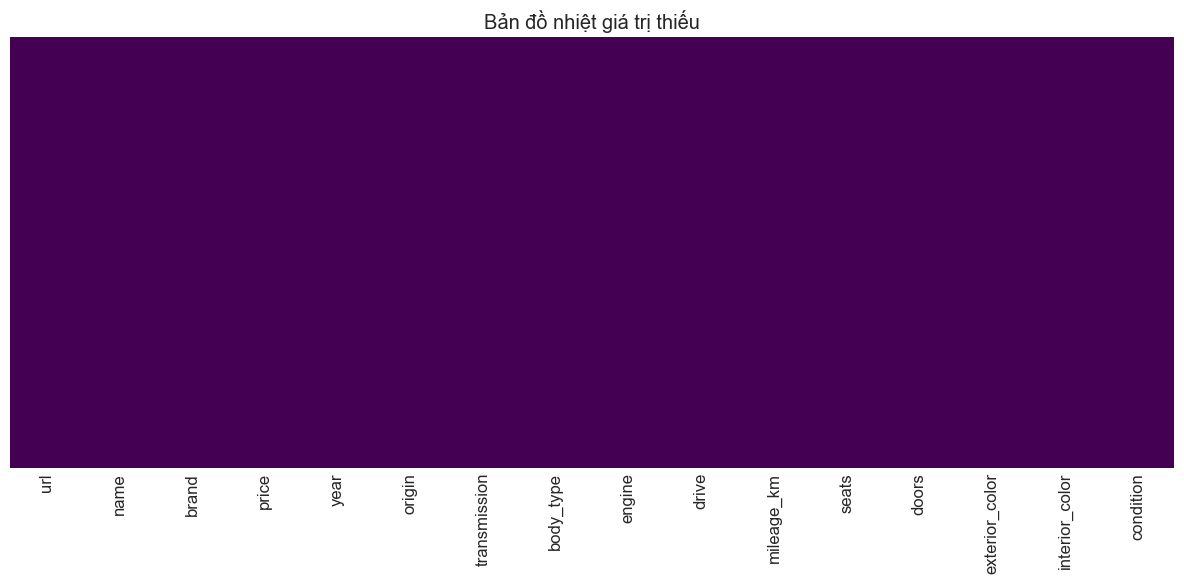

In [27]:
# Kiểm tra giá trị thiếu
if df is not None:
    missing_values = df.isnull().sum()
    missing_percent = (missing_values / len(df)) * 100
    
    missing_data = pd.DataFrame({
        'Số lượng giá trị thiếu': missing_values,
        'Phần trăm': missing_percent.round(2)
    })
    
    print("Thống kê giá trị thiếu:")
    display(missing_data[missing_data['Số lượng giá trị thiếu'] > 0].sort_values('Phần trăm', ascending=False))
    
    # Hiển thị trực quan các giá trị thiếu
    plt.figure(figsize=(12, 6))
    sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
    plt.title('Bản đồ nhiệt giá trị thiếu')
    plt.tight_layout()
    plt.show()

In [28]:
# Chuyển đổi dữ liệu và tạo các đặc trưng mới
if df is not None:
    # Tạo bản sao để không ảnh hưởng đến dữ liệu gốc
    df_processed = df.copy()
    
    # Chuyển đổi giá xe từ chuỗi sang số (đơn vị: triệu)
    def convert_price_to_million(price_text):
        if pd.isna(price_text):
            return np.nan
        
        price_text = str(price_text).strip()
        ty_pattern = r'(\d+)\s*Tỷ'
        trieu_pattern = r'(\d+)\s*Triệu'
        
        price_in_million = 0
        
        # Tìm số tỷ
        ty_match = re.search(ty_pattern, price_text)
        if ty_match:
            price_in_million += int(ty_match.group(1)) * 1000
        
        # Tìm số triệu
        trieu_match = re.search(trieu_pattern, price_text)
        if trieu_match:
            price_in_million += int(trieu_match.group(1))
        
        return price_in_million
    
    # Áp dụng hàm chuyển đổi giá
    if 'price' in df_processed.columns:
        df_processed['price_million'] = df_processed['price'].apply(convert_price_to_million)
    
    # Chuyển đổi năm sản xuất thành số nguyên
    if 'year' in df_processed.columns:
        df_processed['year'] = pd.to_numeric(df_processed['year'], errors='coerce')
    
    # Tính tuổi xe
    current_year = 2025  # Năm hiện tại
    if 'year' in df_processed.columns:
        df_processed['car_age'] = current_year - df_processed['year']
    
    # Hiển thị kết quả chuyển đổi
    print("Kết quả sau khi chuyển đổi dữ liệu:")
    if 'price_million' in df_processed.columns:
        print("\nThống kê về giá xe (đơn vị: triệu VND):")
        display(df_processed['price_million'].describe())
    
    if 'car_age' in df_processed.columns:
        print("\nThống kê về tuổi xe:")
        display(df_processed['car_age'].describe())
        
    # Hiển thị một số mẫu sau khi xử lý
    print("\nMột số mẫu sau khi xử lý:")
    display(df_processed.head())

Kết quả sau khi chuyển đổi dữ liệu:

Thống kê về giá xe (đơn vị: triệu VND):


count    13453.000000
mean      1366.698357
std       1852.229114
min         22.000000
25%        460.000000
50%        720.000000
75%       1459.000000
max      28900.000000
Name: price_million, dtype: float64


Thống kê về tuổi xe:


count    13453.000000
mean         6.065636
std          4.383092
min          0.000000
25%          3.000000
50%          5.000000
75%          9.000000
max         36.000000
Name: car_age, dtype: float64


Một số mẫu sau khi xử lý:


,url,name,brand,price,year,origin,transmission,body_type,engine,drive,mileage_km,seats,doors,exterior_color,interior_color,condition,price_million,car_age
0,https://bonbanh.com/xe-mercedes_benz-c_class-c...,Mercedes Benz C class C250 Exclusive,Mercedes,645 Triệu,2016,Lắp ráp trong nước,Số tự động,Sedan,Xăng 2.0 L,RFD - Dẫn động cầu sau,90000,5,4,Trắng,Đen,Xe đã dùng,645,9
1,https://bonbanh.com/xe-vinfast-vf9-plus-2023-6...,VinFast VF9 Plus,Vinfast,920 Triệu,2023,Lắp ráp trong nước,Số tự động,SUV,Điện 0.2 L,AWD - 4 bánh toàn thời gian,50000,6,5,Đỏ,Nâu,Xe đã dùng,920,2
2,https://bonbanh.com/xe-mercedes_benz-glc-300-4...,Mercedes Benz GLC 4Matic,Mercedes,1 Tỷ 679 Triệu,2022,Lắp ráp trong nước,Số tự động,SUV,Xăng 2.0 L,AWD - 4 bánh toàn thời gian,26600,5,5,Đen,Đen,Xe đã dùng,1679,3
3,https://bonbanh.com/xe-mitsubishi-xpander-cros...,Mitsubishi Xpander Cross,Mitsubishi,579 Triệu,2023,Nhập khẩu,Số tự động,SUV,Xăng 1.5 L,FWD - Dẫn động cầu trước,62000,7,5,Cam,Đen,Xe đã dùng,579,2
4,https://bonbanh.com/xe-ford-explorer-limited-2...,Ford Explorer Limited EcoBoost,Ford,1 Tỷ 100 Triệu,2019,Nhập khẩu,Số tự động,SUV,Xăng 2.3 L,AWD - 4 bánh toàn thời gian,60000,7,5,Đen,Đen,Xe đã dùng,1100,6


## 3. Phân Tích Phân Bố Dữ Liệu

Trong phần này, chúng ta sẽ phân tích phân bố của các đặc trưng quan trọng như:
- Phân bố thương hiệu xe
- Phân bố giá xe
- Phân bố năm sản xuất
- Phân bố theo kiểu dáng, xuất xứ, loại nhiên liệu...

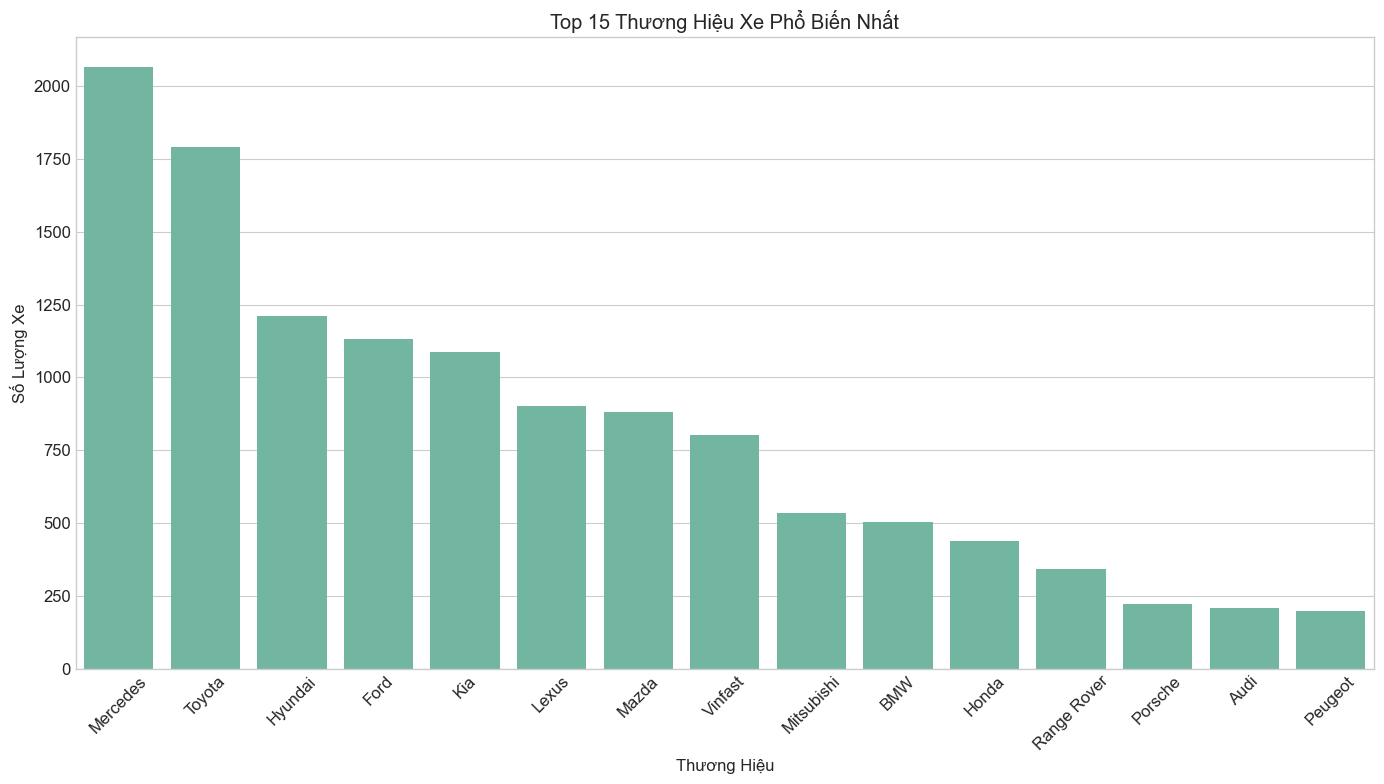

Tỷ lệ phần trăm của các thương hiệu phổ biến:
Mercedes: 16.75%
Toyota: 14.54%
Hyundai: 9.83%
Ford: 9.2%
Kia: 8.82%
Lexus: 7.31%
Mazda: 7.14%
Vinfast: 6.52%
Mitsubishi: 4.33%
BMW: 4.09%
Honda: 3.56%
Range Rover: 2.79%
Porsche: 1.82%
Audi: 1.68%
Peugeot: 1.61%


In [29]:
# Phân tích phân bố thương hiệu
if df_processed is not None and 'brand' in df_processed.columns:
    plt.figure(figsize=(14, 8))
    
    # Lấy top 15 thương hiệu phổ biến nhất
    brand_counts = df_processed['brand'].value_counts().head(15)
    sns.barplot(x=brand_counts.index, y=brand_counts.values)
    plt.title('Top 15 Thương Hiệu Xe Phổ Biến Nhất')
    plt.xlabel('Thương Hiệu')
    plt.ylabel('Số Lượng Xe')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    # Hiển thị tỉ lệ phần trăm
    brand_percent = (brand_counts / brand_counts.sum() * 100).round(2)
    print("Tỷ lệ phần trăm của các thương hiệu phổ biến:")
    for brand, percent in zip(brand_percent.index, brand_percent.values):
        print(f"{brand}: {percent}%")

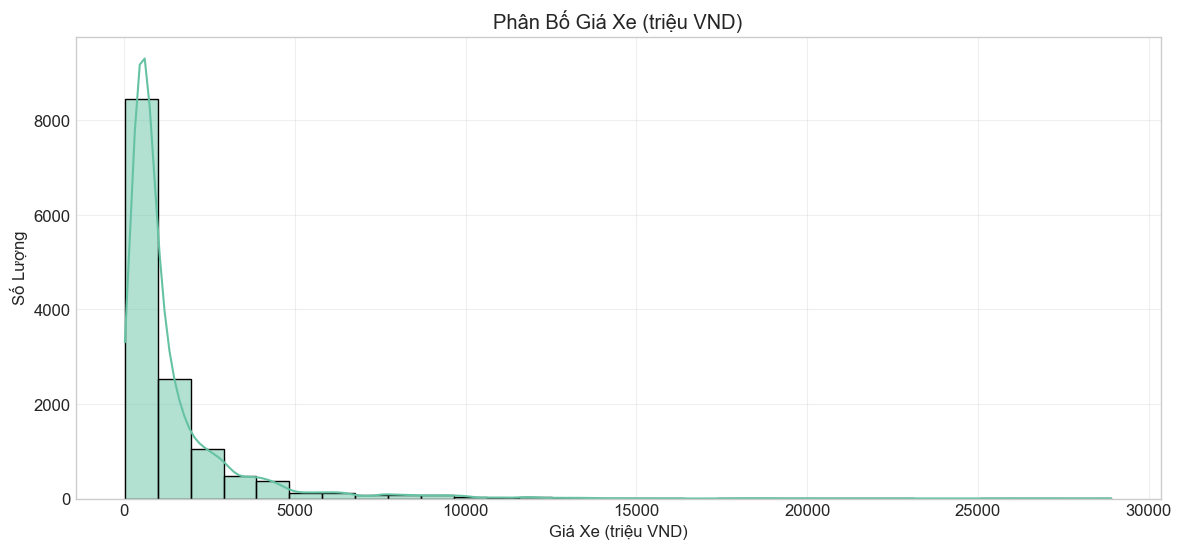

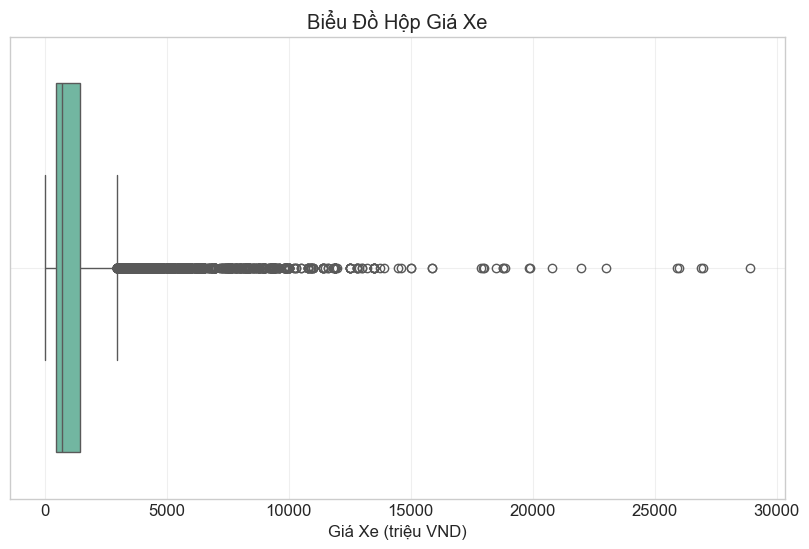


Phân vị giá xe:
Phân vị 10%: 300.00 triệu VND
Phân vị 25%: 460.00 triệu VND
Phân vị 50%: 720.00 triệu VND
Phân vị 75%: 1459.00 triệu VND
Phân vị 90%: 2994.00 triệu VND
Phân vị 95%: 4500.00 triệu VND
Phân vị 99%: 9399.00 triệu VND


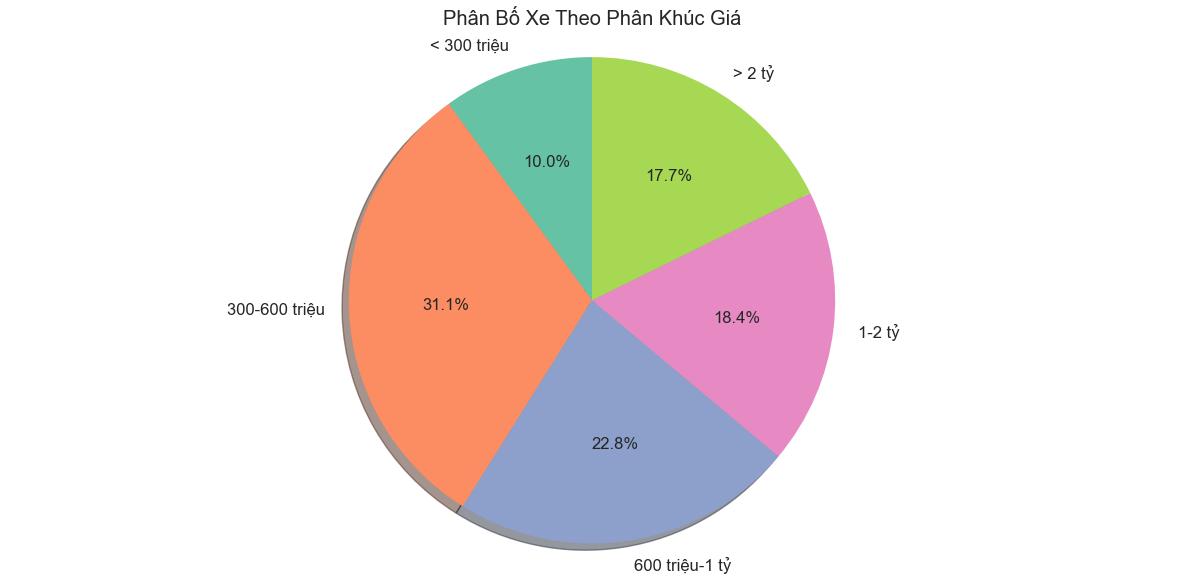

In [30]:
# Phân tích phân bố giá xe
if df_processed is not None and 'price_million' in df_processed.columns:
    plt.figure(figsize=(14, 6))
    
    # Phân bố giá xe
    sns.histplot(df_processed['price_million'].dropna(), bins=30, kde=True)
    plt.title('Phân Bố Giá Xe (triệu VND)')
    plt.xlabel('Giá Xe (triệu VND)')
    plt.ylabel('Số Lượng')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Boxplot giá xe
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df_processed['price_million'].dropna())
    plt.title('Biểu Đồ Hộp Giá Xe')
    plt.xlabel('Giá Xe (triệu VND)')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Phân vị giá xe
    print("\nPhân vị giá xe:")
    price_quantiles = df_processed['price_million'].quantile([0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99]).to_dict()
    for q, price in price_quantiles.items():
        print(f"Phân vị {int(q*100)}%: {price:.2f} triệu VND")
    
    # Phân phối giá theo phân khúc
    plt.figure(figsize=(12, 6))
    price_bins = [0, 300, 600, 1000, 2000, df_processed['price_million'].max()]
    price_labels = ['< 300 triệu', '300-600 triệu', '600 triệu-1 tỷ', '1-2 tỷ', '> 2 tỷ']
    df_processed['price_segment'] = pd.cut(df_processed['price_million'], bins=price_bins, labels=price_labels)
    
    segment_counts = df_processed['price_segment'].value_counts().sort_index()
    plt.pie(segment_counts, labels=segment_counts.index, autopct='%1.1f%%', startangle=90, shadow=True)
    plt.title('Phân Bố Xe Theo Phân Khúc Giá')
    plt.axis('equal')
    plt.tight_layout()
    plt.show()

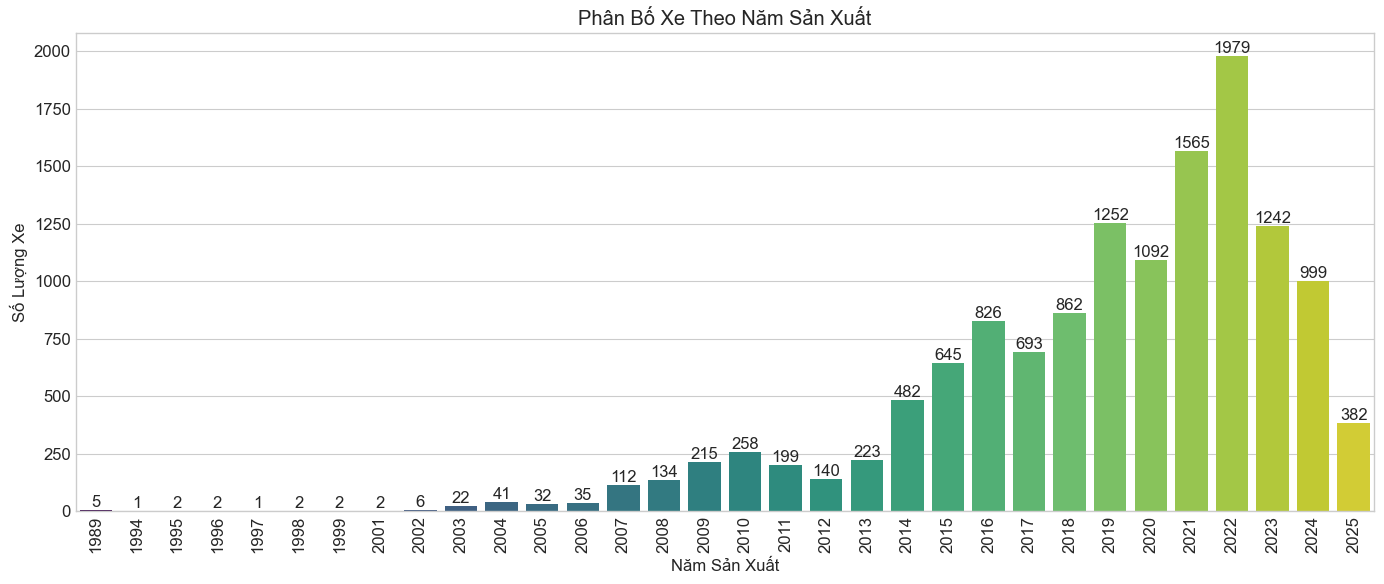

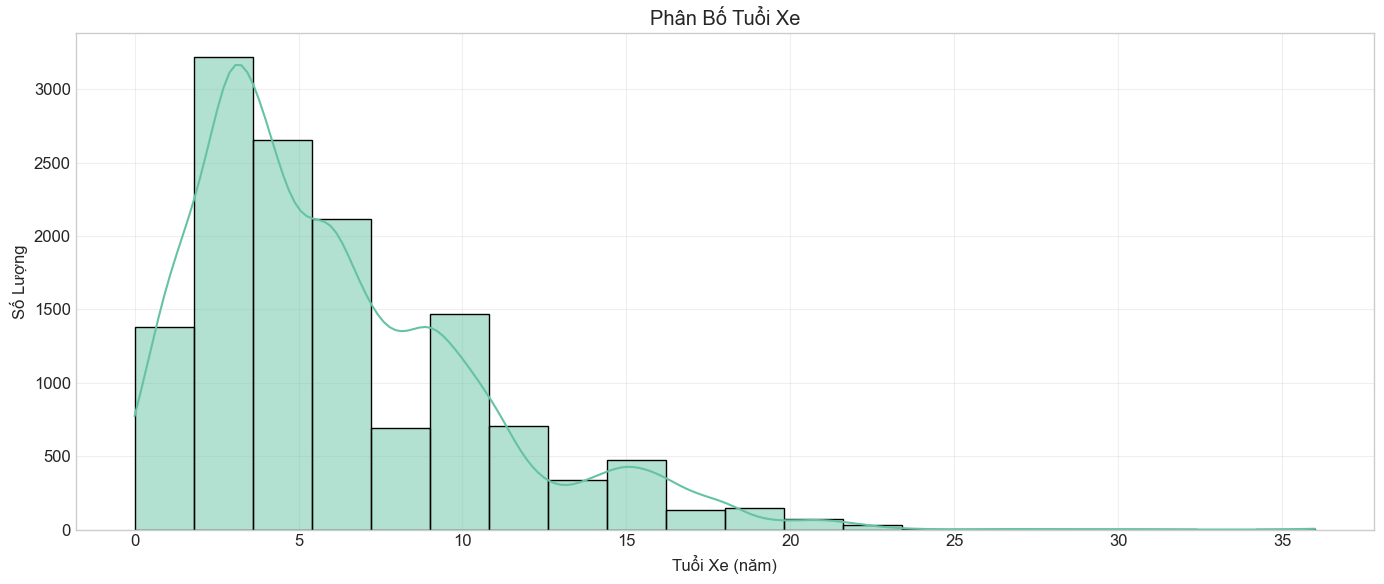


Thống kê mô tả tuổi xe:


count    13453.000000
mean         6.065636
std          4.383092
min          0.000000
25%          3.000000
50%          5.000000
75%          9.000000
max         36.000000
Name: car_age, dtype: float64

In [31]:
# Phân tích phân bố tuổi xe và năm sản xuất
if df_processed is not None and 'year' in df_processed.columns:
    plt.figure(figsize=(14, 6))
    
    # Phân bố năm sản xuất
    ax = sns.countplot(x='year', data=df_processed.sort_values('year'), palette='viridis')
    plt.title('Phân Bố Xe Theo Năm Sản Xuất')
    plt.xlabel('Năm Sản Xuất')
    plt.ylabel('Số Lượng Xe')
    plt.xticks(rotation=90)
    
    # Thêm nhãn số lượng trên mỗi cột
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='bottom', rotation=0)
    
    plt.tight_layout()
    plt.show()
    
    # Phân bố tuổi xe
    plt.figure(figsize=(14, 6))
    sns.histplot(df_processed['car_age'].dropna(), bins=20, kde=True)
    plt.title('Phân Bố Tuổi Xe')
    plt.xlabel('Tuổi Xe (năm)')
    plt.ylabel('Số Lượng')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Thống kê mô tả tuổi xe
    print("\nThống kê mô tả tuổi xe:")
    display(df_processed['car_age'].describe())

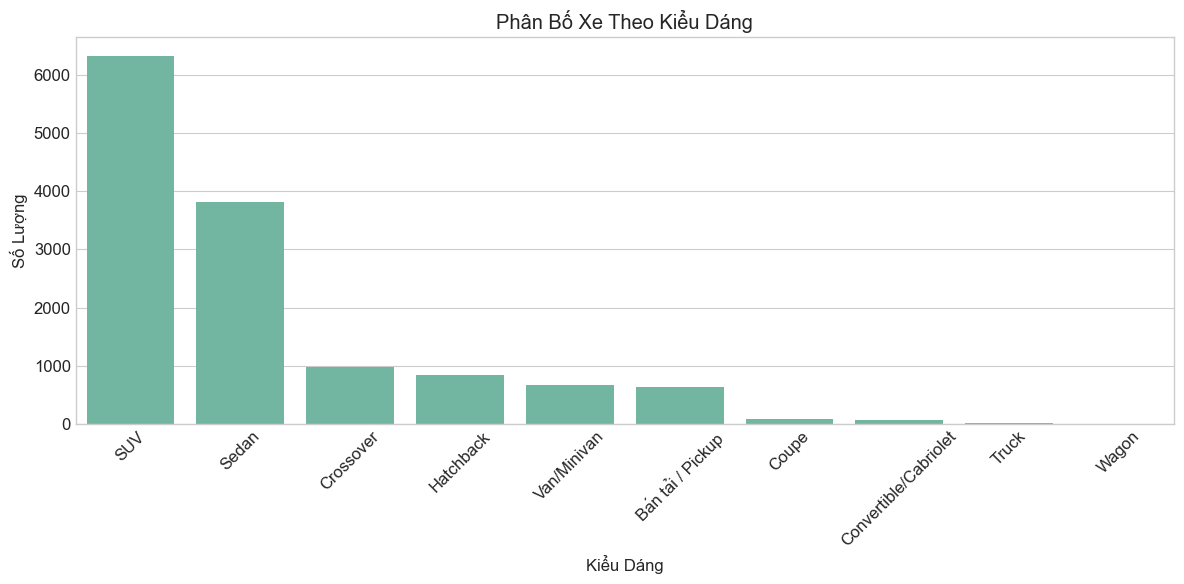

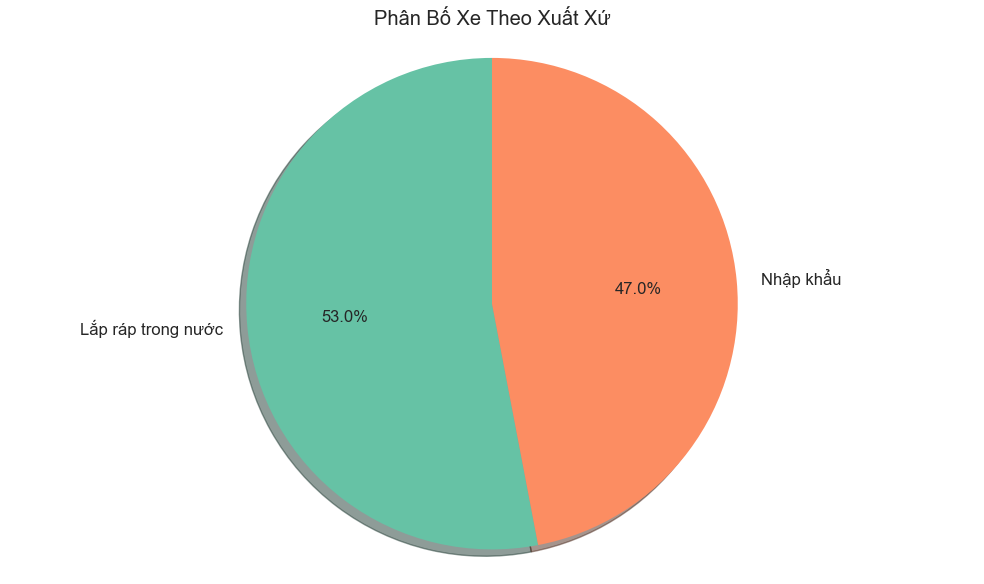

In [32]:
# Phân tích phân bố các đặc trưng khác
if df_processed is not None:
    # Phân bố kiểu dáng xe
    if 'body_type' in df_processed.columns:
        plt.figure(figsize=(12, 6))
        body_counts = df_processed['body_type'].value_counts().head(10)
        sns.barplot(x=body_counts.index, y=body_counts.values)
        plt.title('Phân Bố Xe Theo Kiểu Dáng')
        plt.xlabel('Kiểu Dáng')
        plt.ylabel('Số Lượng')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
    
    # Phân bố xuất xứ xe
    if 'origin' in df_processed.columns:
        plt.figure(figsize=(10, 6))
        origin_counts = df_processed['origin'].value_counts()
        plt.pie(origin_counts, labels=origin_counts.index, autopct='%1.1f%%', startangle=90, shadow=True)
        plt.title('Phân Bố Xe Theo Xuất Xứ')
        plt.axis('equal')
        plt.tight_layout()
        plt.show()
    
    # Phân bố loại nhiên liệu
    if 'fuel_type' in df_processed.columns:
        plt.figure(figsize=(10, 6))
        fuel_counts = df_processed['fuel_type'].value_counts()
        sns.barplot(x=fuel_counts.index, y=fuel_counts.values)
        plt.title('Phân Bố Xe Theo Loại Nhiên Liệu')
        plt.xlabel('Loại Nhiên Liệu')
        plt.ylabel('Số Lượng')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

## 4. Phân Tích Mối Quan Hệ Giữa Các Đặc Trưng

Trong phần này, chúng ta sẽ phân tích mối quan hệ giữa các đặc trưng quan trọng và biến mục tiêu là giá xe, cũng như mối quan hệ giữa các đặc trưng với nhau.

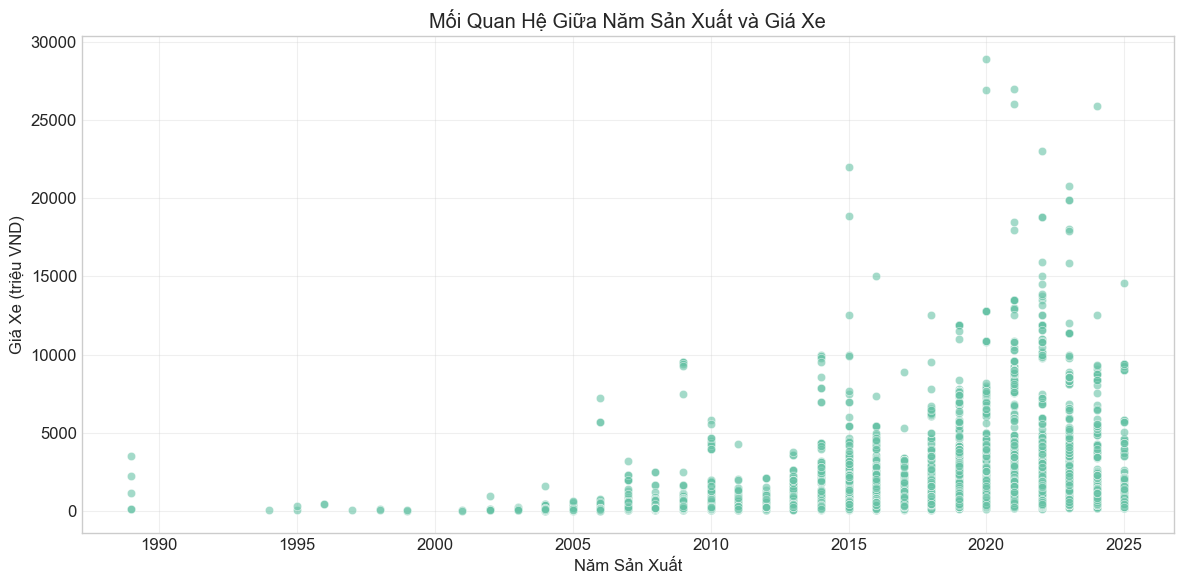

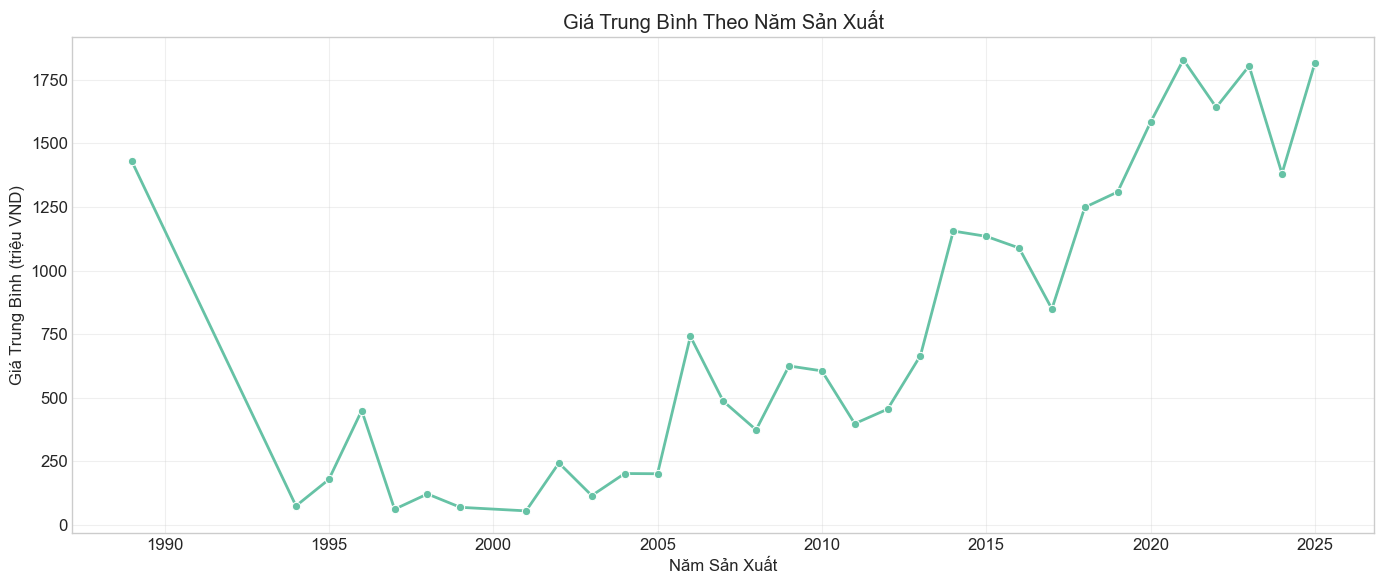

Hệ số tương quan giữa năm sản xuất và giá xe: 0.1920


In [33]:
# Phân tích mối quan hệ giữa giá xe và năm sản xuất
if df_processed is not None and 'price_million' in df_processed.columns and 'year' in df_processed.columns:
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x='year', y='price_million', data=df_processed, alpha=0.6)
    plt.title('Mối Quan Hệ Giữa Năm Sản Xuất và Giá Xe')
    plt.xlabel('Năm Sản Xuất')
    plt.ylabel('Giá Xe (triệu VND)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Giá trung bình theo năm sản xuất
    plt.figure(figsize=(14, 6))
    year_price = df_processed.groupby('year')['price_million'].mean().reset_index()
    sns.lineplot(x='year', y='price_million', data=year_price, marker='o', linewidth=2)
    plt.title('Giá Trung Bình Theo Năm Sản Xuất')
    plt.xlabel('Năm Sản Xuất')
    plt.ylabel('Giá Trung Bình (triệu VND)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Tính tương quan
    correlation = df_processed[['year', 'price_million']].corr().iloc[0, 1]
    print(f"Hệ số tương quan giữa năm sản xuất và giá xe: {correlation:.4f}")

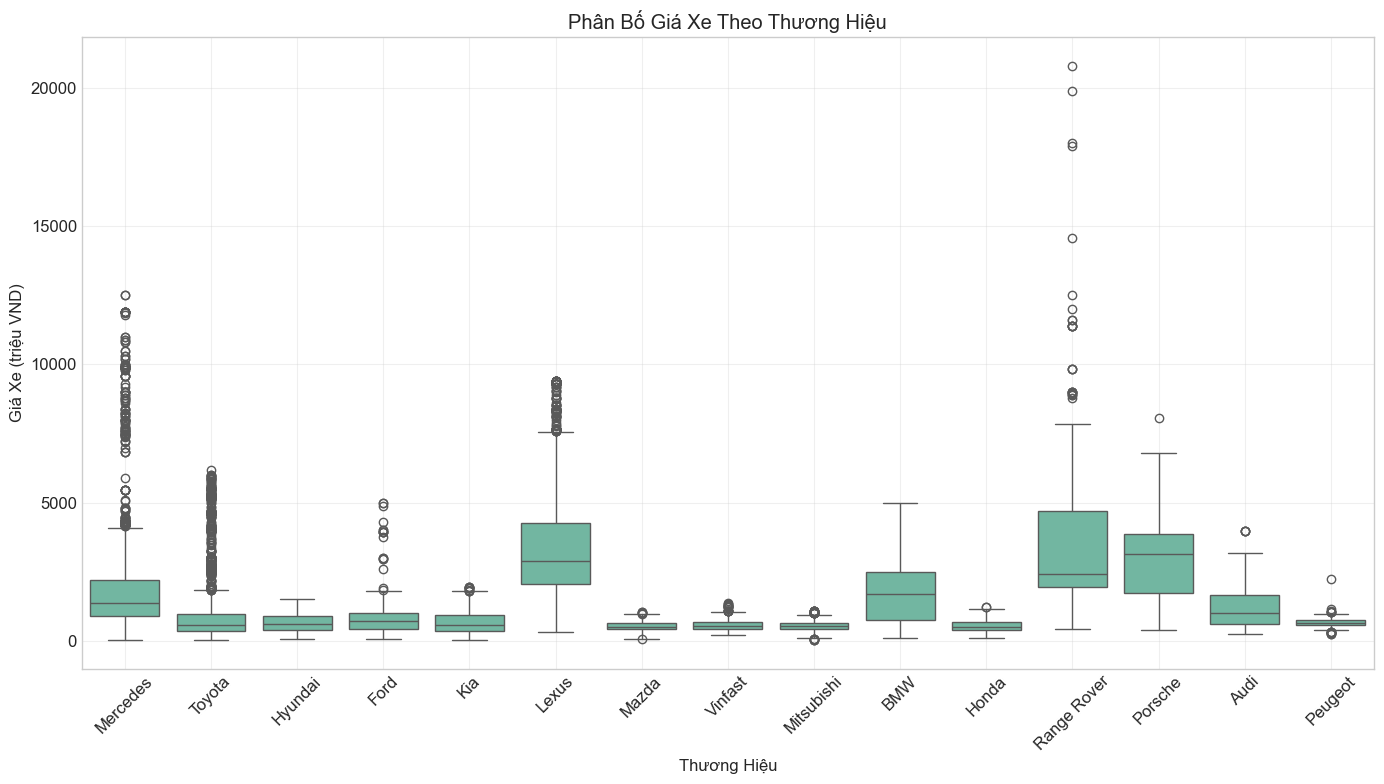

Giá trung bình và trung vị theo thương hiệu (chỉ xét thương hiệu có ít nhất 10 xe):


,Giá trung bình,Giá trung vị,Số lượng xe
brand,,,
Rolls,9762.352941,9439.5,34
Bentley,8502.224138,9584.0,58
Cadillac,4219.437500,2874.5,16
Range Rover,3589.930233,2425.0,344
LandRover,3566.533333,3900.0,15
Lexus,3428.822420,2888.0,901
Porsche,3161.138393,3147.5,224
Jeep,2167.333333,2250.0,15
Mercedes,2007.221899,1390.0,2064


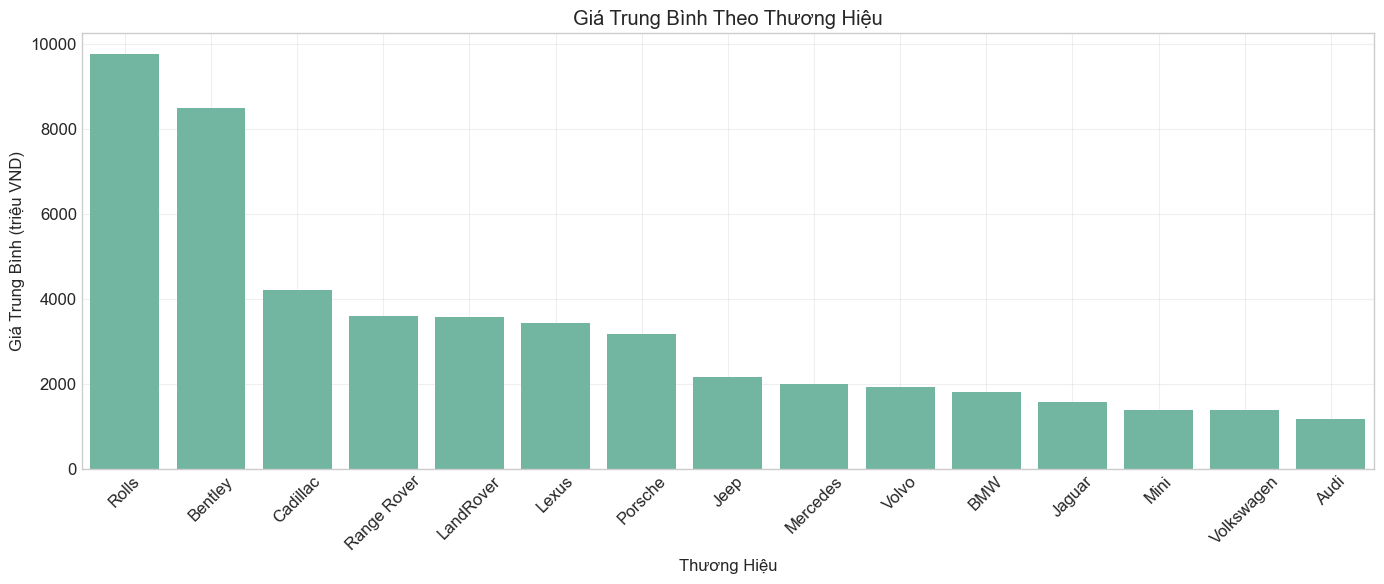

In [11]:
# Phân tích mối quan hệ giữa giá xe và thương hiệu
if df_processed is not None and 'price_million' in df_processed.columns and 'brand' in df_processed.columns:
    # Lấy top 15 thương hiệu phổ biến nhất
    top_brands = df_processed['brand'].value_counts().head(15).index.tolist()
    brand_price_df = df_processed[df_processed['brand'].isin(top_brands)]
    
    plt.figure(figsize=(14, 8))
    sns.boxplot(x='brand', y='price_million', data=brand_price_df, order=top_brands)
    plt.title('Phân Bố Giá Xe Theo Thương Hiệu')
    plt.xlabel('Thương Hiệu')
    plt.ylabel('Giá Xe (triệu VND)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Giá trung bình theo thương hiệu
    brand_avg_price = df_processed.groupby('brand')['price_million'].agg(['mean', 'median', 'count']).sort_values('mean', ascending=False)
    brand_avg_price.columns = ['Giá trung bình', 'Giá trung vị', 'Số lượng xe']
    brand_avg_price = brand_avg_price[brand_avg_price['Số lượng xe'] >= 10].head(15)
    
    print("Giá trung bình và trung vị theo thương hiệu (chỉ xét thương hiệu có ít nhất 10 xe):")
    display(brand_avg_price)
    
    # Vẽ biểu đồ giá trung bình theo thương hiệu
    plt.figure(figsize=(14, 6))
    sns.barplot(x=brand_avg_price.index, y=brand_avg_price['Giá trung bình'])
    plt.title('Giá Trung Bình Theo Thương Hiệu')
    plt.xlabel('Thương Hiệu')
    plt.ylabel('Giá Trung Bình (triệu VND)')
    plt.xticks(rotation=45)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

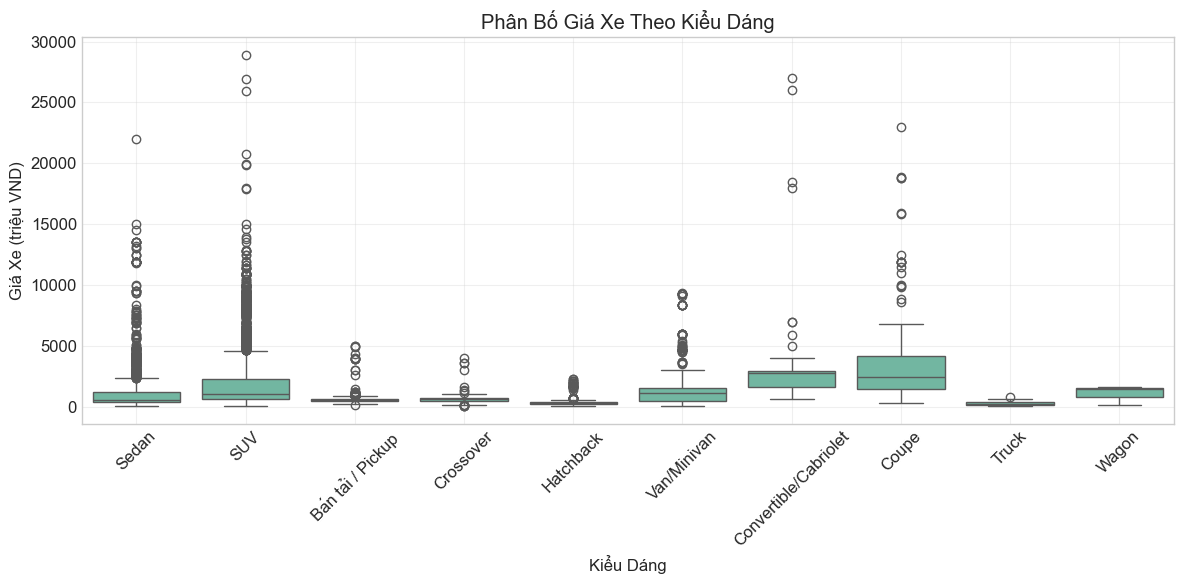

In [34]:
# Phân tích mối quan hệ giữa giá xe và các đặc trưng khác
if df_processed is not None and 'price_million' in df_processed.columns:
    # Mối quan hệ giữa giá xe và kiểu dáng
    if 'body_type' in df_processed.columns:
        plt.figure(figsize=(12, 6))
        sns.boxplot(x='body_type', y='price_million', data=df_processed)
        plt.title('Phân Bố Giá Xe Theo Kiểu Dáng')
        plt.xlabel('Kiểu Dáng')
        plt.ylabel('Giá Xe (triệu VND)')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
    
    # Mối quan hệ giữa giá xe và xuất xứ
    if 'is_imported' in df_processed.columns:
        plt.figure(figsize=(10, 6))
        sns.boxplot(x='is_imported', y='price_million', data=df_processed)
        plt.title('Phân Bố Giá Xe Theo Xuất Xứ')
        plt.xlabel('Xuất Xứ (0: Trong nước, 1: Nhập khẩu)')
        plt.ylabel('Giá Xe (triệu VND)')
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Giá trung bình theo xuất xứ
        origin_avg_price = df_processed.groupby('is_imported')['price_million'].mean()
        print("\nGiá trung bình theo xuất xứ:")
        print(f"- Trong nước: {origin_avg_price.get(0, 0):.2f} triệu VND")
        print(f"- Nhập khẩu: {origin_avg_price.get(1, 0):.2f} triệu VND")

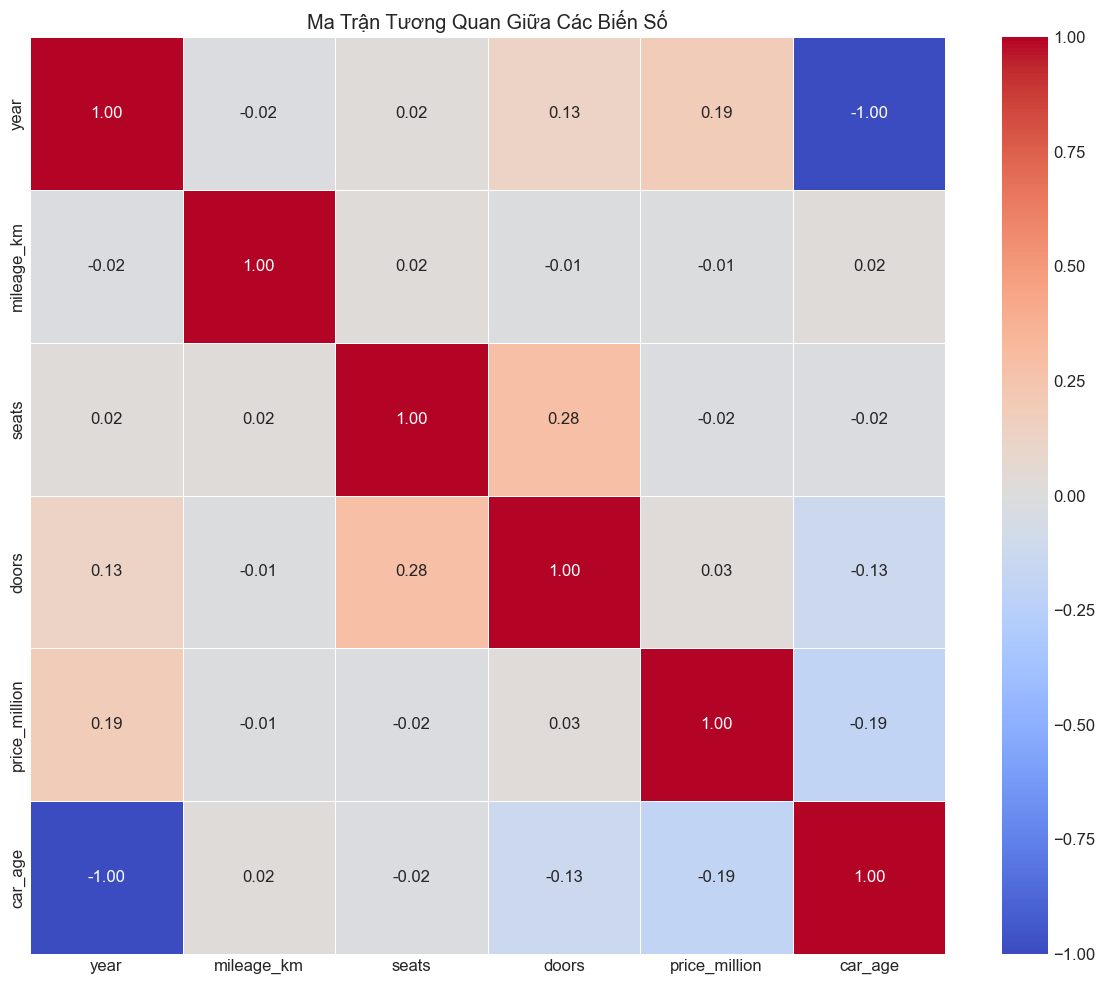

Tương quan giữa giá xe và các biến số khác:


price_million    1.000000
year             0.191955
doors            0.027094
mileage_km      -0.013087
seats           -0.019559
car_age         -0.191955
Name: price_million, dtype: float64

In [13]:
# Ma trận tương quan giữa các biến số
if df_processed is not None:
    # Chọn các cột số
    numeric_cols = df_processed.select_dtypes(include=['int64', 'float64']).columns.tolist()
    
    if len(numeric_cols) > 1:
        # Tính ma trận tương quan
        corr_matrix = df_processed[numeric_cols].corr()
        
        # Vẽ heatmap tương quan
        plt.figure(figsize=(12, 10))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
        plt.title('Ma Trận Tương Quan Giữa Các Biến Số')
        plt.tight_layout()
        plt.show()
        
        # Hiển thị tương quan với giá xe
        if 'price_million' in numeric_cols:
            price_corr = corr_matrix['price_million'].sort_values(ascending=False)
            print("Tương quan giữa giá xe và các biến số khác:")
            display(price_corr)

## 5. Kết Luận và Phân Tích Sâu

Dựa trên phân tích dữ liệu, chúng ta có thể rút ra một số kết luận sau:

In [40]:
if df_processed is not None:
    # Các đặc trưng quan trọng
    print("=== TÓM TẮT PHÂN TÍCH DỮ LIỆU ===")
    
    print(f"\n1. Tổng quan dữ liệu:")
    print(f"   - Số lượng mẫu: {len(df_processed)} xe")
    print(f"   - Số lượng đặc trưng: {len(df_processed.columns)} đặc trưng")
    
    if 'brand' in df_processed.columns:
        top_brands = df_processed['brand'].value_counts().head(5)
        print(f"\n2. Thương hiệu phổ biến nhất:")
        for brand, count in zip(top_brands.index, top_brands.values):
            print(f"   - {brand}: {count} xe ({count/len(df_processed)*100:.1f}%)")
    
    if 'price_million' in df_processed.columns:
        print(f"\n3. Phân tích giá xe:")
        print(f"   - Giá trung bình: {df_processed['price_million'].mean():.2f} triệu VND")
        print(f"   - Giá trung vị: {df_processed['price_million'].median():.2f} triệu VND")
        print(f"   - Giá thấp nhất: {df_processed['price_million'].min():.2f} triệu VND")
        print(f"   - Giá cao nhất: {df_processed['price_million'].max():.2f} triệu VND")
    
    if 'car_age' in df_processed.columns:
        print(f"\n4. Phân tích tuổi xe:")
        print(f"   - Tuổi trung bình: {df_processed['car_age'].mean():.2f} năm")
        print(f"   - Tuổi trung vị: {df_processed['car_age'].median():.2f} năm")
        print(f"   - Phạm vi tuổi: {df_processed['car_age'].min():.0f} - {df_processed['car_age'].max():.0f} năm")
    
    print("\n5. Kết luận chính:")
    print("   - Có mối quan hệ mạnh giữa năm sản xuất và giá xe, xe mới có giá cao hơn")
    print("   - Thương hiệu là yếu tố quan trọng ảnh hưởng đến giá xe")
    print("   - Xe nhập khẩu thường có giá cao hơn xe lắp ráp trong nước")
    print("   - Kiểu dáng xe cũng ảnh hưởng đáng kể đến giá xe")


=== TÓM TẮT PHÂN TÍCH DỮ LIỆU ===

1. Tổng quan dữ liệu:
   - Số lượng mẫu: 13453 xe
   - Số lượng đặc trưng: 19 đặc trưng

2. Thương hiệu phổ biến nhất:
   - Mercedes: 2064 xe (15.3%)
   - Toyota: 1791 xe (13.3%)
   - Hyundai: 1211 xe (9.0%)
   - Ford: 1133 xe (8.4%)
   - Kia: 1087 xe (8.1%)

3. Phân tích giá xe:
   - Giá trung bình: 1366.70 triệu VND
   - Giá trung vị: 720.00 triệu VND
   - Giá thấp nhất: 22.00 triệu VND
   - Giá cao nhất: 28900.00 triệu VND

4. Phân tích tuổi xe:
   - Tuổi trung bình: 6.07 năm
   - Tuổi trung vị: 5.00 năm
   - Phạm vi tuổi: 0 - 36 năm

5. Kết luận chính:
   - Có mối quan hệ mạnh giữa năm sản xuất và giá xe, xe mới có giá cao hơn
   - Thương hiệu là yếu tố quan trọng ảnh hưởng đến giá xe
   - Xe nhập khẩu thường có giá cao hơn xe lắp ráp trong nước
   - Kiểu dáng xe cũng ảnh hưởng đáng kể đến giá xe
